Note: This notebook is titled "stereoisomerism". However, the focus is on deteremining and visualizing the stereochemistry of individual compounds.

In [ ]:
!pip install rdkit
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 36.8 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw, MolFromSmiles
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
import numpy as np
from PIL import Image
import io

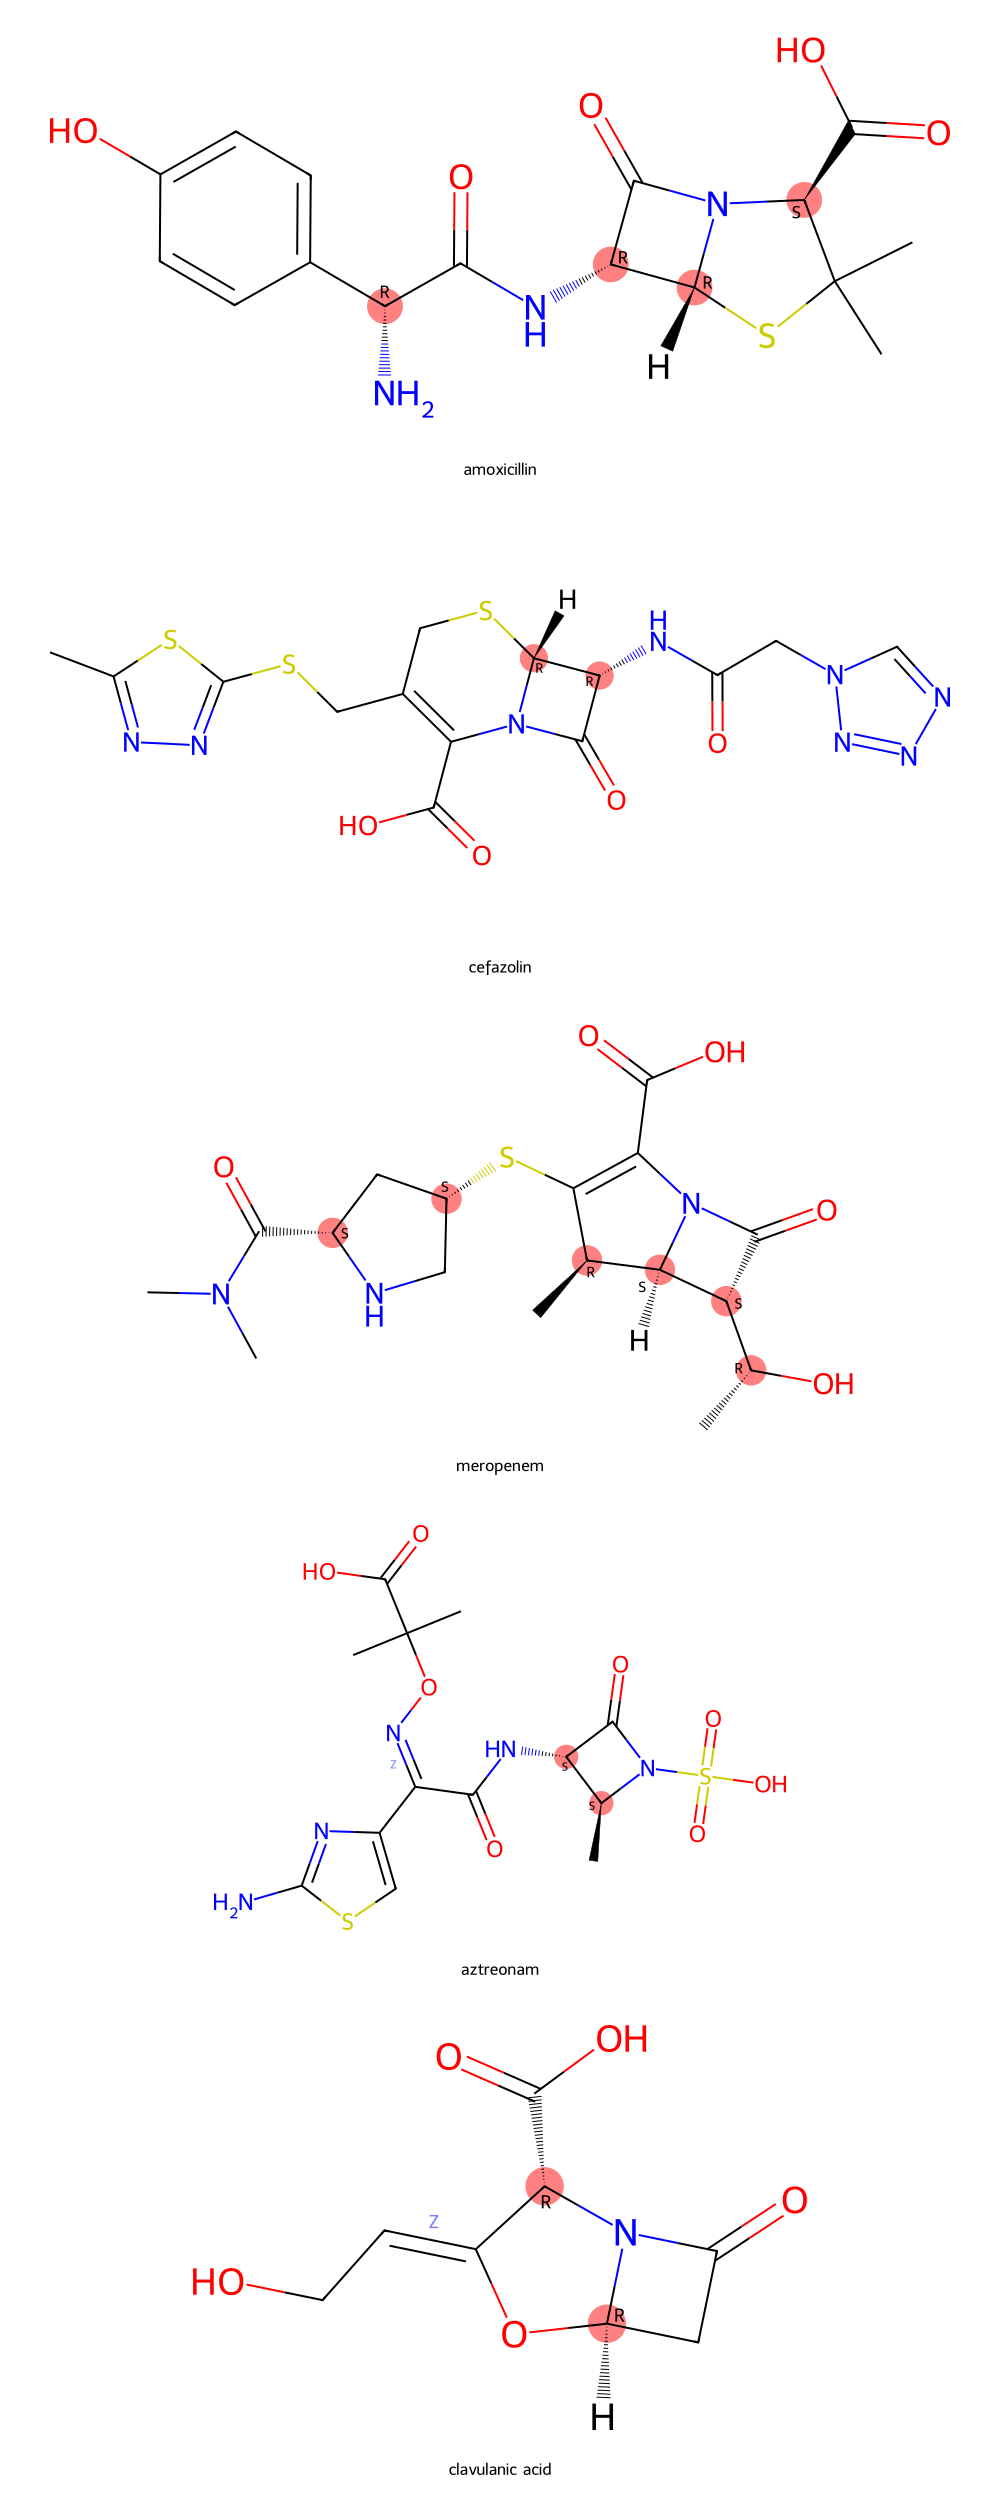

In [ ]:
data_smiles = pd.read_csv('https://raw.githubusercontent.com/sharonlae77/useful_codes/main/data/data_smiles.csv')
molecule = [MolFromSmiles(i) for i in data_smiles['smiles']]
chiral_tags = [Chem.AssignAtomChiralTagsFromStructure(mol) for mol in molecule]
names = [name for name in data_smiles['name']]

highlight_lists = []

for mol in molecule:
    atom_index_list = []
    atom_label_list = []
    highlight_list = []
    for atom in mol.GetAtoms():
        if atom.HasProp('_CIPCode'):
            atom_index = atom.GetIdx()
            atom_index_list.append(atom_index)
            atom_label = atom.GetProp('_CIPCode')
            atom_label_list.append(atom_label)

    Chem.AssignStereochemistry(mol, cleanIt=True, force=True)

    atoms = [mol.GetAtomWithIdx(i) for i in atom_index_list]
    for i in range(len(atoms)):
        atoms[i].SetProp("atomNote", atom_label_list[i])
    highlight_lists.append(atom_index_list)

    bond_index_list = []
    bond_label_list = []
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE:
            bond_index = bond.GetIdx()
            stereo = bond.GetStereo()
            if stereo == Chem.BondStereo.STEREOE:
                bond_label_list.append("E")
                bond_index_list.append(bond_index)
            elif stereo == Chem.BondStereo.STEREOZ:
                bond_label_list.append("Z")
                bond_index_list.append(bond_index)

    bonds = [mol.GetBondWithIdx(i) for i in bond_index_list]
    for i in range(len(bonds)):
        bonds[i].SetProp("bondNote", bond_label_list[i])

images = []
img_size = (1000, 500)


for mol, highlights, name in zip(molecule, highlight_lists, names):
    drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
    rdMolDraw2D.PrepareAndDrawMolecule(drawer,
                                       mol,
                                       legend=name,
                                       highlightAtoms=highlights,
                                      )
    drawer.FinishDrawing()
    img_bytes = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(img_bytes))
    images.append(img)

cols = 1
rows = (len(images) + cols - 1) // cols
grid_img = Image.new('RGB', (cols * img_size[0], rows * img_size[1]), color='white')
for idx, img in enumerate(images):
    x = (idx % cols) * img_size[0]
    y = (idx // cols) * img_size[1]
    grid_img.paste(img, (x, y))

grid_img